Available devices: [CudaDevice(id=0)]
Using existing run folder: ./
HDF5 Dataset Keys: <KeysViewHDF5 ['train_encod_data', 'train_recon_data', 'valid_encod_data', 'valid_recon_data']>
train data shape: (1, 6925, 500, 2)
test data shape: (1, 6925, 500, 2)
Number of learnable parameters in the encoder: 4.3 k
Number of learnable parameters in the genetor: 20.8 k
Number of learnable parameters in the reconstructing decoder: 0.0 k
Model loaded from folder
Test MSE: 0.11750609


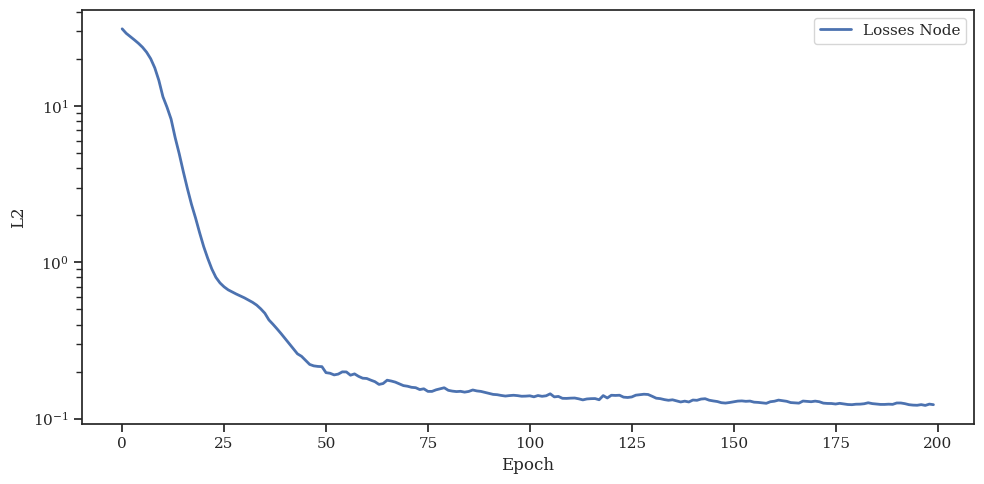

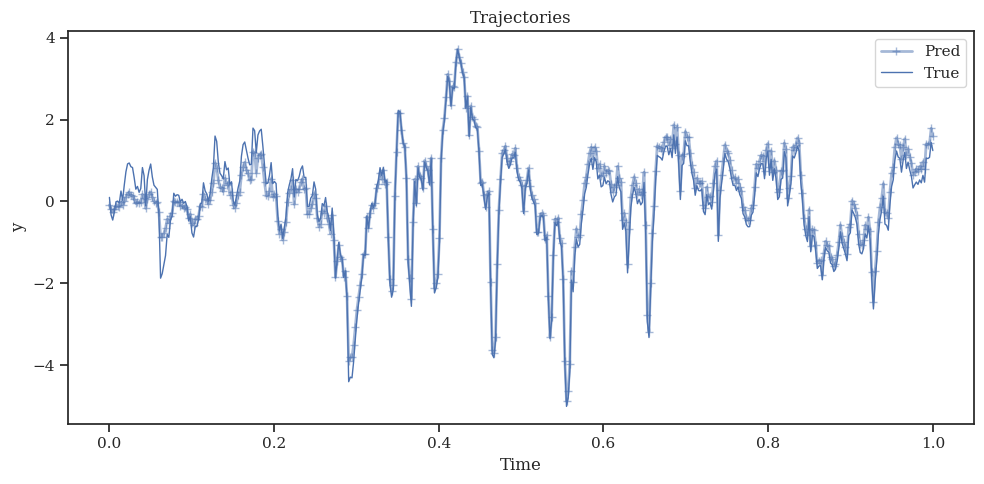

In [1]:
#%%[markdown]

# ## Hierachical LFADS
# Use a Neural Controlled Differential Equation to learn EEG data. Vocab:
# - we learn the initial condition x(0) and the current state x(t) (the map from 0-t)
# - a "segment" is a trajectory
# - We want to beat the SLEEP
# - We base everything on the Davide-Conor LVM project: https://openreview.net/pdf?id=pv2pqnf6U6
# - We want to beat these guys: https://arxiv.org/pdf/2110.14853 (small improvement on LFADS with latents corresponding to behaviour := NCF), and also the Brenner Shallow RNN



#%%
import jax

print("Available devices:", jax.devices())

# from jax import config
# config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

# import matplotlib.pyplot as plt
from neuralhub import *

import optax
import time
import h5py


#%%

SEED = 2025
main_key = jax.random.PRNGKey(SEED)

## Model hps
latent_size = 16
factor_size = 2
mlp_hidden_size = 32
mlp_depth = 4
data_size = 2

## Testing hps
nb_test_trajs = -1
nb_channel_vis = 1

## Optimiser hps
init_lr = 1e-3

## Training hps
print_every = 10
nb_epochs = 200
batch_size = 7695//4
traj_prop_train = 1.0
subsample_skip = 1
train_horizon = 500
variational = True

train = False

## Data hps
data_folder = "./data/new_sleep/" if train else "../../data/new_sleep/"
run_folder = "./runs/241114-152228-Test/" if train else "./"
# run_folder = None if train else "./"


#%%
### Create and setup the run folder
if run_folder==None:
    run_folder = make_run_folder('./runs/')
else:
    print("Using existing run folder:", run_folder)
# _ = setup_run_folder(run_folder, os.path.basename(__file__))


#%%
with h5py.File(data_folder+'dataset.h5', "r") as f:
    print("HDF5 Dataset Keys: %s" % f.keys())
    train_data = np.array(f['train_encod_data'])
    test_data = np.array(f['train_encod_data'])

# train_data = np.load(data_folder+'data.npy').transpose(0, 2, 1)
# ## Min Max Normalization of the data
# train_data = (train_data - np.min(train_data, keepdims=True)) / (np.max(train_data, keepdims=True) - np.min(train_data, keepdims=True))
# test_data = train_data

## Mean and standard deviation of the initial condition

data = train_data[None, :, :train_horizon:, :]
T_horizon = 1.
t_eval = np.linspace(0, T_horizon, data.shape[2])

if nb_test_trajs != -1:
    test_data = test_data[None, :nb_test_trajs, :train_horizon:, :]
else:
    test_data = test_data[None, :, :train_horizon:, :]

if subsample_skip != -1:
    data = data[:, :, :train_horizon:subsample_skip, :]
    t_eval = t_eval[::subsample_skip]
    test_data = test_data[:, :, :train_horizon:subsample_skip, :]

print("train data shape:", data.shape)
print("test data shape:", test_data.shape)


# %%


class NeuralODE(eqx.Module):
    data_size: int
    mlp_hidden_size: int
    mlp_depth: int
    latent_size: int
    variational: bool

    encoder: eqx.Module
    generator: eqx.Module
    decoder_recons: eqx.Module
    # decoder_factor: eqx.Module


    def __init__(self, data_size, latent_size, factor_size, variational, mlp_hidden_size, mlp_depth, key=None):
        self.data_size = data_size
        self.mlp_hidden_size = mlp_hidden_size
        self.mlp_depth = mlp_depth
        self.latent_size = latent_size
        self.variational = variational

        keys = jax.random.split(key, num=4)
        self.encoder = eqx.nn.MLP(data_size, 
                                    latent_size*2 if self.variational else latent_size, 
                                    mlp_hidden_size, 
                                    mlp_depth, 
                                    use_bias=True, 
                                    activation=jax.nn.softplus,
                                    key=keys[0])
        self.generator = eqx.nn.MLP(latent_size, 
                                    latent_size*(data_size+1)*1 if self.variational else latent_size*(data_size+1),
                                    mlp_hidden_size*2, 
                                    mlp_depth+1, 
                                    use_bias=True, 
                                    activation=jax.nn.softplus, 
                                    key=keys[1])
        # self.generator = Generator(1, mlp_hidden_size, data_size+1, key=keys[1])
        # self.decoder_factor = eqx.nn.Linear(latent_size,
        #                                     factor_size,
        #                                     use_bias=True,
        #                                     key=keys[3])
        self.decoder_recons = eqx.nn.Linear(latent_size, 
                                            data_size, 
                                            use_bias=True, 
                                            key=keys[2])

    def __call__(self, xs, t_eval, key):
        """ Forward call of the Neural ODE """

        def vector_field(t, y, args):
            base_key, = args
            key_t = jax.random.fold_in(base_key, (jnp.array([t])*1e9).astype(int)[0])

            ## Forward pass through the encoder
            y_next = self.generator(y).reshape(self.latent_size, 1*(self.data_size+1) if self.variational else self.data_size+1)

            ## Sample and return the next state
            if self.variational:
                # mu_y, logvar_y = jnp.split(y_next, 2, axis=-1)
                mu_y, logvar_y = y_next, jnp.log(jnp.ones_like(y_next) * 0.001**2)
                eps = jax.random.normal(key_t, mu_y.shape)
                y_next = mu_y + eps*jnp.exp(0.5*logvar_y)

            return jax.nn.tanh(y_next)

        def integrate(y0_mu, y0_logvar, key, all_xs):
            if self.variational:
                eps = jax.random.normal(key, y0_mu.shape)
                y0 = y0_mu + eps*jnp.exp(0.5*y0_logvar)
            else:
                y0 = y0_mu

            coeffs = diffrax.backward_hermite_coefficients(t_eval, all_xs)
            control = diffrax.CubicInterpolation(t_eval, coeffs)

            sol = diffrax.diffeqsolve(
                    diffrax.ControlTerm(vector_field, control).to_ode(),
                    diffrax.Tsit5(),
                    args=(key,),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=t_eval[1]-t_eval[0],
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096*5
                )

            return sol.ys

        x0s = xs[:, 0, ...]       ## Shape: (batch, data_size)
        z0s = eqx.filter_vmap(self.encoder)(x0s)        ## Shape: (batch, 2*latent_size)

        if self.variational:
            z0s_mu, z0s_logvar = jnp.split(z0s, 2, axis=-1)
        else:
            z0s_mu, z0s_logvar = z0s, None

        keys = jax.random.split(key, num=x0s.shape[0])

        ## Add time as a channel to all_xs
        all_ts = jnp.ones((xs.shape[0], xs.shape[1], 1)) * t_eval[None, :, None]
        xs = jnp.concatenate((all_ts, xs), axis=-1)

        zs = eqx.filter_vmap(integrate)(z0s_mu, z0s_logvar, keys, xs)        ## Shape: (batch, T, latent_size)

        # x_factors = eqx.filter_vmap(eqx.filter_vmap(self.decoder_factor))(zs)        ## Shape: (batch, T, factor_size)
        x_recons = eqx.filter_vmap(eqx.filter_vmap(self.decoder_recons))(zs)        ## Shape: (batch, T, data_size)

        return x_recons, zs[:,-1,:], (z0s_mu, z0s_logvar)           ## TODO collect the actual factor
        # return x_recons, z0s_mu[:,:], (z0s_mu, z0s_logvar)        ## TODO collect the actual factor



# %%

model_keys = jax.random.split(main_key, num=2)

model = NeuralODE(data_size=data_size, 
                  latent_size=latent_size, 
                  factor_size=factor_size, 
                  variational=variational,
                  mlp_hidden_size=mlp_hidden_size, 
                  mlp_depth=mlp_depth, 
                  key=model_keys[0])

## Print the total number of learnable paramters in the model components
print(f"Number of learnable parameters in the encoder: {count_params(model.encoder)/1000:3.1f} k")
print(f"Number of learnable parameters in the genetor: {count_params(model.generator)/1000:3.1f} k")
print(f"Number of learnable parameters in the reconstructing decoder: {count_params(model.decoder_recons)/1000:3.1f} k")

# %%

def loss_fn(model, batch, key):
    X, t = batch
    X_recons, _, (latents_mu, latents_logvars) = model(X, t, key)

    ## MSE loss
    rec_loss = jnp.mean((X-X_recons)**2, axis=(1,2))

    ### Another reconstruction loss
    # BCE_loss = jnp.sum(-xs*jnp.log(recon_xs) - (1-xs)*jnp.log(1-recon_xs), axis=(1,2,3))

    if model.variational:
        ## KL divergence between two gaussians
        mu, var = latents_mu, jnp.exp(latents_logvars)
        # target_mu, target_var = 0., 6.7**2
        target_mu, target_var = 0., 0.1**2
        # KL_loss = -0.5 * jnp.sum(1 + latents_logvars - latents_mu**2 - jnp.exp(latents_logvars), axis=1)
        KL_loss = 0.5 * jnp.sum(jnp.log(var/target_var) + (target_var + (mu - target_mu)**2)/var - 1, axis=1)
        return jnp.mean(rec_loss + KL_loss), (jnp.mean(rec_loss), jnp.mean(KL_loss))
    else:
        return jnp.mean(rec_loss), (jnp.mean(rec_loss), 0.)
    # return jnp.mean(rec_loss), (jnp.mean(rec_loss), jnp.mean(KL_loss))



@eqx.filter_jit
def train_step(model, batch, opt_state, key):
    print('\nCompiling function "train_step" ...')

    (loss, aux_data), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, batch, key)

    updates, opt_state = opt_node.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss, aux_data


def sample_batch_portion(outputs, t_evals, traj_prop=traj_prop_train):
    """Returns a trajectory of len 20% of the original trajectory """

    if traj_prop == 1.0:
        return outputs, t_evals

    min_len = int(t_evals.shape[0] * traj_prop)
    start_idx = np.random.randint(0, t_evals.shape[0] - min_len)
    end_idx = start_idx + min_len

    ts = t_evals[start_idx:end_idx]
    trajs = outputs[:, start_idx:end_idx, :]

    return trajs, ts




#%%

if train:
    sched_node = optax.exponential_decay(init_value=init_lr, transition_steps=10, decay_rate=0.99)
    opt_node = optax.adam(sched_node)
    opt_state_node = opt_node.init(eqx.filter(model, eqx.is_array))

    train_key, _ = jax.random.split(main_key)

    nb_data_points = data.shape[1]
    losses_node = []

    print(f"\n\n=== Beginning Training ... ===")
    start_time = time.time()

    for epoch in range(nb_epochs):

        nb_batches = 0
        loss_sum_node = 0.

        for i in range(0, nb_data_points, batch_size):
            # batch = (data[0,i:i+batch_size, ...], t_eval)
            batch = sample_batch_portion(*(data[0, i:i+batch_size, ...], t_eval))

            train_key, _ = jax.random.split(train_key)
            model, opt_state_node, loss, (rec_loss, kl_loss) = train_step(model, batch, opt_state_node, train_key)

            loss_sum_node += loss

            nb_batches += 1

        loss_epoch_node = loss_sum_node/nb_batches
        losses_node.append(loss_epoch_node)

        if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
            print(f"    Epoch: {epoch:-5d}      LossNode: {loss_epoch_node:.12f}      Rec_Loss: {rec_loss:.12f}      KL_Loss: {kl_loss:.12f}", flush=True)
            eqx.tree_serialise_leaves(run_folder+"model_lfads.eqx", model) ## just for checkpoint elsewhere

    wall_time = time.time() - start_time
    time_in_hmsecs = seconds_to_hours(wall_time)
    print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

    print(f"Training Complete, saving model to folder: {run_folder}")
    eqx.tree_serialise_leaves(run_folder+"model_lfads.eqx", model)
    np.save(run_folder+"losses_lfads.npy", np.array(losses_node))

else:
    model = eqx.tree_deserialise_leaves(run_folder+"model_lfads.eqx", model)
    try:
        losses_node = np.load(run_folder+"losses_lfads.npy")
    except:
        losses_node = []

    print("Model loaded from folder")


# %%
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sbplot(np.array(losses_node), x_label='Epoch', y_label='L2', y_scale="log", label='Losses Node', ax=ax, dark_background=False);
plt.legend()
plt.draw();
plt.savefig(run_folder+"loss_lfads.png", dpi=100, bbox_inches='tight')



# %%

## Test the model

def test_model(model, batch):
    X, t = batch
    X_hat = model(X, t, main_key)
    return X_hat


X, t = sample_batch_portion(*(test_data[0, :, ...], t_eval), traj_prop=1.0)
X_hat, X_lats, Z0s = test_model(model, (X, t))

print(f"Test MSE: {jnp.mean((X-X_hat)**2):.8f}")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors*10

## Visualize channels trajectories
traj_id = np.random.randint(0, X.shape[0])
ch_vis_start = np.random.randint(0, X.shape[-1]-nb_channel_vis+1)
for i in range(ch_vis_start, ch_vis_start+nb_channel_vis):
    if i==0:
        sbplot(t, X_hat[traj_id, :,i], "+-", x_label='Time', y_label='y', label=f'Pred', title=f'Trajectories', ax=ax, alpha=0.5, color=colors[i])
        sbplot(t, X[traj_id, :,i], "-", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(t, X_hat[traj_id, :,i], "x-", x_label='Time', y_label='y', ax=ax, alpha=0.5, color=colors[i])
        sbplot(t, X[traj_id, :,i], "-", lw=1, ax=ax, color=colors[i])

## Limit ax x and y axis to (-5,5)
plt.draw();
# plt.ylim(-30/10000, 30/10000)

## Save the plot
plt.savefig(run_folder+"results_lfads.png", dpi=100, bbox_inches='tight')

# ## Save the results to a npz file
# np.savez(run_folder+"predictions_test.npz", trajs=X, recons=X_hat, latents=X_lats)
np.savez(run_folder+"latents.npz", latents=X_lats)

In [ ]:
# %matplotlib qt

# %%[markdown]
## Setup UMAP and plot the latents


# %%
## Visualize the latent space after a UMAP projection of X_lats
import umap
import pandas as pd

# ## Load the latels for the plotting from the 'anotations.csv'
# labels = []
# with open(data_folder+'annotations.csv', 'r') as f:
#     for line in f:
#         if 'subject' not in line:
#             human = int(line.split(',')[0].strip())
#             sleep_phase = int(line.split(',')[1].strip())
#             labels.append((human, sleep_phase))

## Davide's approach to reading CSV
annotations = pd.read_csv(data_folder+'train_annotations.csv')
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# invert the dictionary
event_id_inv = {v: k for k, v in event_id.items()}
# annotations = annotations[annotations['subject'] == 2]
# indices = annotations.index.to_list()


In [26]:
# %matplotlib qt

### My original way of plotting things
# reducer = umap.UMAP(n_components=2, min_dist=0., n_neighbors=15, metric='euclidean')
# X_lats_umap = reducer.fit_transform(X_lats, min_dist=0.1)

# colors = np.array(labels)
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# # sbplot(X_lats_umap[:,0], X_lats_umap[:,1], "o", x_label='UMAP1', y_label='UMAP2', title='UMAP of Latent Space', ax=ax)

# ## Plot using scatter and collors
# ax.scatter(X_lats_umap[:,0], X_lats_umap[:,1], c=colors[:,0], cmap='tab20', alpha=0.5)

### The Davide way of plotting things
# %matplotlib inline
reducer = umap.UMAP(n_components=2, min_dist=0.0, n_neighbors=15, metric='euclidean')
# embeddings = reducer.fit_transform(X_lats[indices, :]) # TEST
embeddings = reducer.fit_transform(X_lats[:, :]) # TEST



[5, 3, 4, 2, 1]


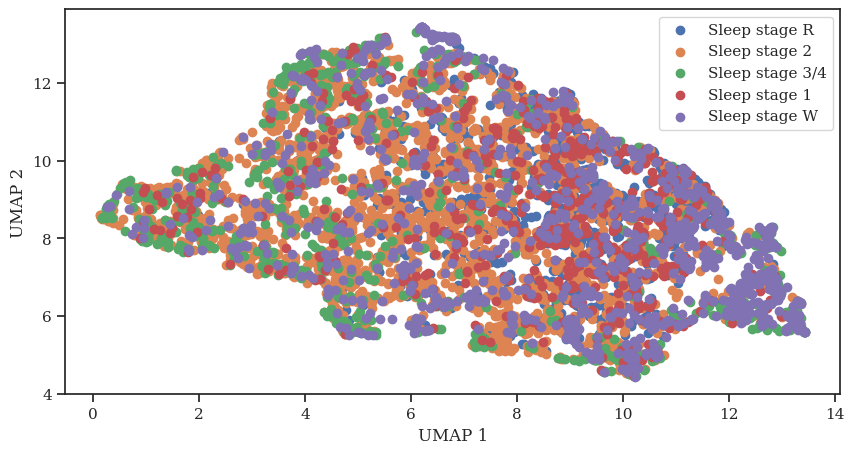

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# unique_conditions = annotations['condition'].sample(frac=1).unique()
# unique_conditions = annotations['condition'].unique()
unique_conditions = [5, 3, 4, 2, 1]

print(unique_conditions)

colors=["red", "green", "blue", "orange", "cyan"]
for i, condition in enumerate(unique_conditions):
    condition_mask = annotations['condition'] == condition
    # Plot a scatter plot giving a distinct color to each condition from event_id_inv
    # plt.scatter(embeddings[condition_mask, 0], embeddings[condition_mask, 1], label=event_id_inv[condition], alpha=0.5, c=colors[i])
    plt.scatter(embeddings[condition_mask, 0], embeddings[condition_mask, 1], label=event_id_inv[condition])
    #plt.scatter(embeddings[condition_mask, 0], embeddings[condition_mask, 1], label=condition)
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')


# %%

plt.draw();
plt.savefig(run_folder+"umap_latents.png", dpi=100, bbox_inches='tight')